Benchmark PCA and Logistic Regression Model

In [15]:
%pip install polars
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import pyarrow
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import cm
import numpy as np
import polars as pl
import pandas as pd
from glob import glob
# Append the directory containing `merge_tools.py` to the Python path
sys.path.append('../notebooks/utils/')

In [2]:
# Importing functions from merge_tools.py
def merge_n_case_ids(
    n_ids: int = 10000,
    data_dir: str = '/kaggle/input/cr-newagg/new_aggs',
    path_to_base: str = '/kaggle/input/datasets-cr/train_base.parquet',
    use_0: bool = True,
    as_pandas: bool = True,
    random_state: int = 28
) -> pl.DataFrame | pd.DataFrame:
    '''
    Function to merge selected case_id from parquet files, returns subset case_id from the merged dataset.

    Parameters
    ----------
    n_ids : Number of case_ids to sample initially and return (int)
    data_dir : Path to processed parquet files directory (str)
    path_to_base : Path to base file (str)
    use_0 : Use num_group1 == 0 (bool)
    as_pandas : Return as pandas DataFrame
    random_seed : Random seed (int)
    '''
    # Read the base dataframe and sample case_ids
    if as_pandas:
        base_df = pd.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, random_state=random_state).tolist()
    else:
        base_df = pl.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, seed=random_state).to_list()

    # Define the file pattern for fetching files
    file_pattern = '*grouped_0.parquet' if use_0 else '*grouped_rest.parquet'
    file_paths = glob(data_dir + '/' + file_pattern)

    # Initialize the merged DataFrame filtering the base DataFrame
    if as_pandas:
        df = base_df[base_df['case_id'].isin(case_ids)]
    else:
        df = base_df.filter(pl.col('case_id').is_in(case_ids))

    # Merge DataFrames with only the selected case_ids
    for path in file_paths:
        if as_pandas:
            temp = pd.read_parquet(path)
            temp = temp[temp['case_id'].isin(case_ids)]
            df = pd.merge(df, temp, on='case_id', how='outer')
        else:
            temp = pl.read_parquet(path)
            temp = temp.filter(pl.col('case_id').is_in(case_ids))
            df = df.join(temp, on='case_id', how='outer')

    # Convert to pandas if required and using Polars
    if as_pandas and isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    return df

In [32]:
# Setting up the file paths and parameters
base_path = '../data/raw/parquet_files/train/train_base.parquet'
data_dir = '../data/processed/grouped/new_aggs/'

# Choose parameters
n_ids = 1500  # let's start by processing only 800 case_ids
use_0 = True  # parameter choice
as_pandas = True  # Return result as pandas DataFrame
random_state=28 


In [33]:
# Merge using the chosen function
merged_data = merge_n_case_ids(n_ids=n_ids, data_dir=data_dir, path_to_base=base_path, use_0=use_0, as_pandas=as_pandas)


In [34]:
# Now 'merged_data' contains your merged data
merged_data

,case_id,date_decision,MONTH,WEEK_NUM,target,empls_employedfrom_796D_distinct,empls_employedfrom_796D_min_year,empls_employedfrom_796D_min_month,empls_employedfrom_796D_min_day,empls_employedfrom_796D_max_year,...,amtdebitincoming_4809443A_median,amtdebitoutgoing_4809440A_median,amtdepositbalance_4809441A_median,amtdepositincoming_4809444A_median,amtdepositoutgoing_4809442A_median,amtdebitincoming_4809443A_sum,amtdebitoutgoing_4809440A_sum,amtdepositbalance_4809441A_sum,amtdepositincoming_4809444A_sum,amtdepositoutgoing_4809442A_sum
0,956,2019-01-12,201901,1,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2253,2019-01-23,201901,3,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2658,2019-01-25,201901,3,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3876,2019-02-05,201902,5,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4927,2019-02-15,201902,6,1,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2700981,2020-09-23,202009,90,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1496,2701122,2020-09-23,202009,90,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1497,2701628,2020-09-25,202009,90,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,2702781,2020-10-02,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#Since the data contains categorical features with missing values, we can replace NaNs with a new category, such as "Unknown". 
#This approach is particularly useful if we suspect that the absence of data could itself be meaningful.
categorical_columns = merged_data.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    merged_data[col] = merged_data[col].fillna('Unknown')


/var/folders/lz/bgsxthys6f17dbj0wmykkhs00000gn/T/ipykernel_2475/3387946708.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data[col] = merged_data[col].fillna('Unknown')


In [36]:
# Drop the object columns from the DataFrame
merged_data.drop(columns=categorical_columns, inplace=True)

# Print the new DataFrame information to confirm columns are deleted
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 1346 entries, case_id to amtdepositoutgoing_4809442A_sum
dtypes: float64(1233), int32(2), int64(4), int8(99), uint32(8)
memory usage: 14.4 MB
None


In [37]:
date_columns = [col for col in merged_data.columns if 'date' in col] 

In [38]:
# Identify all numeric columns
numeric_cols = merged_data.select_dtypes(include=['number']).columns

# Fill NaN values with the mean of each respective column
merged_data[numeric_cols] = merged_data[numeric_cols].apply(lambda x: x.fillna(x.mean()))

In [39]:
print(merged_data.head()) # Display the first few rows of the merged dataframe

   case_id   MONTH  WEEK_NUM  target  empls_employedfrom_796D_distinct  \
0      956  201901         1       0                               1.0   
1     2253  201901         3       0                               1.0   
2     2658  201901         3       0                               1.0   
3     3876  201902         5       0                               1.0   
4     4927  201902         6       1                               1.0   

   empls_employedfrom_796D_min_year  empls_employedfrom_796D_min_month  \
0                               NaN                                NaN   
1                               NaN                                NaN   
2                               NaN                                NaN   
3                               NaN                                NaN   
4                               NaN                                NaN   

   empls_employedfrom_796D_min_day  empls_employedfrom_796D_max_year  \
0                              NaN    

In [11]:
print(merged_data[numeric_cols].isnull().sum())

case_id                             0
MONTH                               0
WEEK_NUM                            0
target                              0
empls_employedfrom_796D_distinct    0
                                   ..
amtdebitincoming_4809443A_sum       0
amtdebitoutgoing_4809440A_sum       0
amtdepositbalance_4809441A_sum      0
amtdepositincoming_4809444A_sum     0
amtdepositoutgoing_4809442A_sum     0
Length: 1346, dtype: int64


In [12]:
# Assuming 'target' should not be included as it might be your dependent variable and not part of X_train or X_valid
numeric_cols = [col for col in numeric_cols if col != 'target']

# Verify the columns now
print(numeric_cols)

['case_id', 'MONTH', 'WEEK_NUM', 'empls_employedfrom_796D_distinct', 'empls_employedfrom_796D_min_year', 'empls_employedfrom_796D_min_month', 'empls_employedfrom_796D_min_day', 'empls_employedfrom_796D_max_year', 'empls_employedfrom_796D_max_month', 'empls_employedfrom_796D_max_day', 'addres_district_368M_freq', 'addres_role_871L_freq', 'addres_zip_823M_freq', 'conts_role_79M_freq', 'empls_economicalst_849M_freq', 'empls_employer_name_740M_freq', 'relatedpersons_role_762T_freq', 'addres_district_368M_binary_0', 'addres_district_368M_binary_1', 'addres_district_368M_binary_2', 'addres_district_368M_binary_3', 'addres_district_368M_binary_4', 'addres_district_368M_binary_5', 'addres_district_368M_binary_6', 'addres_district_368M_binary_7', 'addres_district_368M_binary_8', 'addres_role_871L_binary_0', 'addres_role_871L_binary_1', 'addres_zip_823M_binary_0', 'addres_zip_823M_binary_1', 'addres_zip_823M_binary_2', 'addres_zip_823M_binary_3', 'addres_zip_823M_binary_4', 'addres_zip_823M_bina

In [ ]:
merged_data['date_decision'] = pd.to_datetime(merged_data['date_decision'])
print(merged_data['date_decision'].dtype)

In [13]:
# Assume the target variable is named 'target'
X = merged_data.drop('target', axis=1)
y = merged_data['target']

In [14]:
X = X.fillna(-999)

In [15]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)


In [16]:
# Scale the features for only numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_valid_scaled = scaler.transform(X_valid[numeric_cols])

In [17]:
#Convert these back to DataFrames to retain column labels:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=numeric_cols, index=X_valid.index)

In [20]:
X_train_final = pd.concat([X_train.drop(columns=numeric_cols), X_train_scaled], axis=1)
X_valid_final = pd.concat([X_valid.drop(columns=numeric_cols), X_valid_scaled], axis=1)

In [21]:
# Align the features of validation set to match the training set
X_valid_final = X_valid_final.reindex(columns=X_train_final.columns, fill_value=0)

In [22]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('logistic', LogisticRegression(solver='saga', random_state=42))
])


In [23]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],  # Number of components to keep
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strengths
}

In [24]:
# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_final, y_train)  # Use X_train_final, which includes all preprocessing


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-pack

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             param_grid={'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'pca__n_components': [5, 10, 15, 20, 25, 30]},
             scoring='roc_auc', verbose=1)

In [26]:
# Predict probabilities on the validation set
y_pred_prob = grid_search.best_estimator_.predict_proba(X_valid_final)[:, 1]

# Compute AUC
auc_score = roc_auc_score(y_valid, y_pred_prob)
print(f"Validation AUC: {auc_score:.3f}")

Validation AUC: 0.540


In [27]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'logistic__C': 0.01, 'pca__n_components': 30}


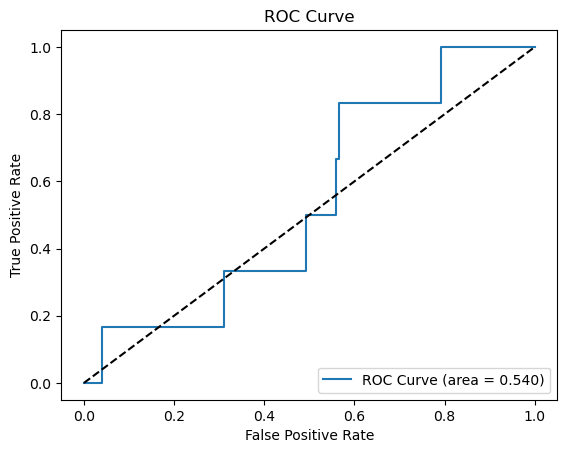

In [28]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.3f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


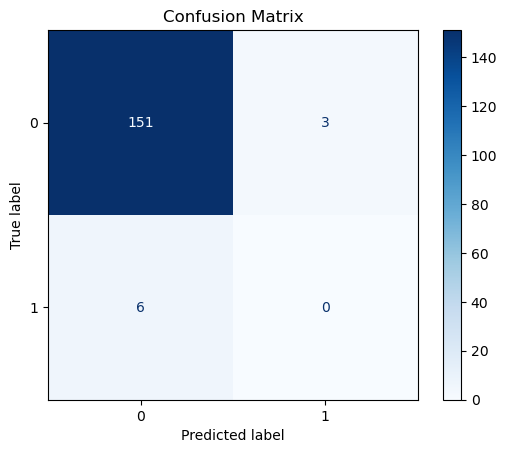

Best parameters found: {'logistic__C': 0.01, 'pca__n_components': 30}
Accuracy: 94.38%


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Predict class labels on the validation set
y_pred = grid_search.best_estimator_.predict(X_valid_final)

# Generate and display the confusion matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Output the best parameters
print("Best parameters found:", grid_search.best_params_)

# Calculate and print the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy:.2%}")  # Printing as a percentage


In [30]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
    title : string, title of the chart
    X : array-like, shape (n_samples, n_features), training vector
    y : array-like, shape (n_samples) or (n_samples, n_features), target values
    ylim : tuple, shape (ymin, ymax), Defines minimum and maximum yvalues plotted
    cv : int, cross-validation generator or an iterable
    n_jobs : int or None, optional (default=None), number of jobs to run in parallel
    train_sizes : array-like, shape (n_ticks,), percentage of training instances to generate learning curve
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-pack

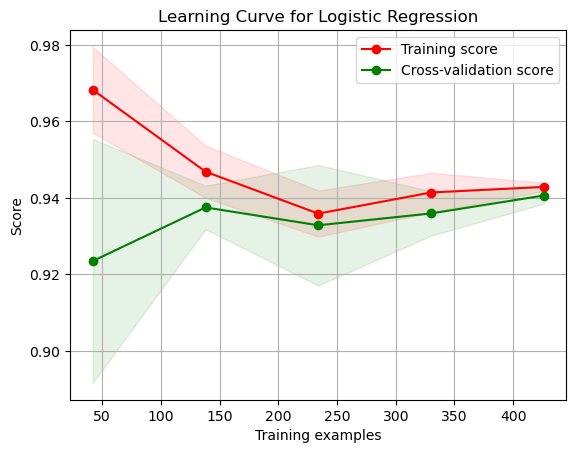

In [31]:
# Use the best estimator from your previous grid search
best_estimator = grid_search.best_estimator_

# Generate the learning curve
plot_learning_curve(estimator=best_estimator, title='Learning Curve for Logistic Regression',
                    X=X_train_final, y=y_train, cv=3, n_jobs=-1)

# Show plot
plt.show()
